In [5]:
from tensorflow import keras
from models.ts_cnn import MULTI_CLASS_TS_CNN_23 as ts_cnn
import numpy as np
import matplotlib.pyplot as plt
# from utils.normalisation import min_max

In [6]:
# %cd Desktop/pyscript/stf_main/

In [7]:
# Reading Data
slip_acc = np.loadtxt('data/multiclass_training_data/Slips/incidents_acc.txt')
slip_gyro = np.loadtxt('data/multiclass_training_data/Slips/incidents_gyro.txt')
trip_acc = np.loadtxt('data/multiclass_training_data/Trips/incidents_acc.txt')
trip_gyro = np.loadtxt('data/multiclass_training_data/Trips/incidents_gyro.txt')
no_incident_acc = np.loadtxt('data/multiclass_training_data/Base Case Walking/no_incidents_acc.txt')
no_incident_gyro = np.loadtxt('data/multiclass_training_data/Base Case Walking/no_incidents_gyro.txt')
chaotic_acc = np.loadtxt("data/multiclass_training_data/JW Data/cwalking_acc.txt")
chaotic_gyro = np.loadtxt("data/multiclass_training_data/JW Data/cwalking_gyro.txt")

x_noise_acc = np.random.rand(200, 200)
x_noise_gyro = np.random.rand(200, 200)


In [8]:

# Stacking
x_slip = np.stack([slip_acc, slip_gyro], axis=1)
x_trip = np.stack([trip_acc, trip_gyro], axis=1)
x_no_incident = np.stack([no_incident_acc, no_incident_gyro], axis=1)
x_chaotic_walking = np.stack([chaotic_acc, chaotic_gyro], axis=1)
x_noise = np.stack([x_noise_acc, x_noise_gyro], axis=1)

x_negative = np.concatenate([x_noise, x_no_incident, x_chaotic_walking])
x_incidents = np.concatenate([x_slip, x_trip])

x = np.concatenate([x_negative, x_slip, x_trip], axis=0)

# Labels
y_slip = np.ones(x_slip.shape[0]).astype(int)
y_trip = np.ones(x_trip.shape[0]) + 1
y_trip = y_trip.astype(int)
y_negative = np.zeros(x_negative.shape[0]).astype(int)
y_all = np.concatenate([y_negative, y_slip, y_trip])
y = keras.utils.to_categorical(y_all)

print(f'x slip: {x_slip.shape}')
print(f'x trip: {x_trip.shape}')
print(f'x no incident: {x_negative.shape}')
print('____________________________________')

#Check for nans
print(f'x: {x.shape}')
print(f'nans: {np.any(np.isnan(x))}')
print(f'y: {y.shape}')

x slip: (254, 2, 200)
x trip: (244, 2, 200)
x no incident: (910, 2, 200)
____________________________________
x: (1408, 2, 200)
nans: False
y: (1408, 3)


In [9]:
def min_max(data):
    """
    Normalize the data to the range [0, 1].
    """
    min_val = np.min(data)
    max_val = np.max(data)
    if max_val - min_val == 0:
        return np.zeros_like(data)  # Handle constant arrays
    return (data - min_val) / (max_val - min_val)


# Assuming x is your 3D array with shape (samples, channels, features)
x_normalized = np.zeros_like(x)

for sample in range(x.shape[0]):  # iterate over samples
    for channel in range(x.shape[1]):  # iterate over channels (acc and gyro)
        x_normalized[sample, channel, :] = min_max(x[sample, channel, :])



In [10]:
print("Original data shape:", x.shape)
print("Normalized data shape:", x_normalized.shape)
print("Original data range:", np.min(x), "-", np.max(x))
print("Normalized data range:", np.min(x_normalized), "-", np.max(x_normalized))

# Check if each sample is indeed normalized to [0, 1]
for i in range(min(5, x.shape[0])):  # Check first 5 samples
    print(f"Sample {i} range:", np.min(x_normalized[i]), "-", np.max(x_normalized[i]))

Original data shape: (1408, 2, 200)
Normalized data shape: (1408, 2, 200)
Original data range: -9.81 - 3304.5274086629215
Normalized data range: 0.0 - 1.0
Sample 0 range: 0.0 - 1.0
Sample 1 range: 0.0 - 1.0
Sample 2 range: 0.0 - 1.0
Sample 3 range: 0.0 - 1.0
Sample 4 range: 0.0 - 1.0


In [11]:
# Shuffle data
idx = np.random.permutation(len(x_normalized))
x = x_normalized[idx]
y = y[idx]
y_all = y_all[idx]

In [24]:
model = ts_cnn()

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
#     ]

optimizer = keras.optimizers.Adam(learning_rate=0.00002)
model.compile(optimizer=optimizer,
                loss=["CategoricalCrossentropy"],
                metrics=["accuracy"])


In [25]:
epochs = 300
batch_size = 64
model.fit(
    [x[:,0], x[:,1]],
    y,
    batch_size=batch_size,
    epochs=epochs,
    # callbacks=callbacks,
    validation_split=0.4,
    verbose=2,
)
history = model.history.history

Epoch 1/300
14/14 - 1s - loss: 1.2818 - accuracy: 0.2263 - val_loss: 1.1201 - val_accuracy: 0.1755 - 1s/epoch - 95ms/step
Epoch 2/300
14/14 - 0s - loss: 1.1473 - accuracy: 0.3709 - val_loss: 1.1518 - val_accuracy: 0.1755 - 153ms/epoch - 11ms/step
Epoch 3/300
14/14 - 0s - loss: 1.0781 - accuracy: 0.4171 - val_loss: 1.1823 - val_accuracy: 0.1755 - 153ms/epoch - 11ms/step
Epoch 4/300
14/14 - 0s - loss: 1.0403 - accuracy: 0.4585 - val_loss: 1.2049 - val_accuracy: 0.1755 - 153ms/epoch - 11ms/step
Epoch 5/300
14/14 - 0s - loss: 1.0140 - accuracy: 0.4964 - val_loss: 1.2182 - val_accuracy: 0.1755 - 153ms/epoch - 11ms/step
Epoch 6/300
14/14 - 0s - loss: 0.9808 - accuracy: 0.5308 - val_loss: 1.2237 - val_accuracy: 0.1755 - 153ms/epoch - 11ms/step
Epoch 7/300
14/14 - 0s - loss: 0.9658 - accuracy: 0.5450 - val_loss: 1.2214 - val_accuracy: 0.1755 - 146ms/epoch - 10ms/step
Epoch 8/300
14/14 - 0s - loss: 0.9411 - accuracy: 0.5699 - val_loss: 1.2092 - val_accuracy: 0.1755 - 151ms/epoch - 11ms/step
Epo

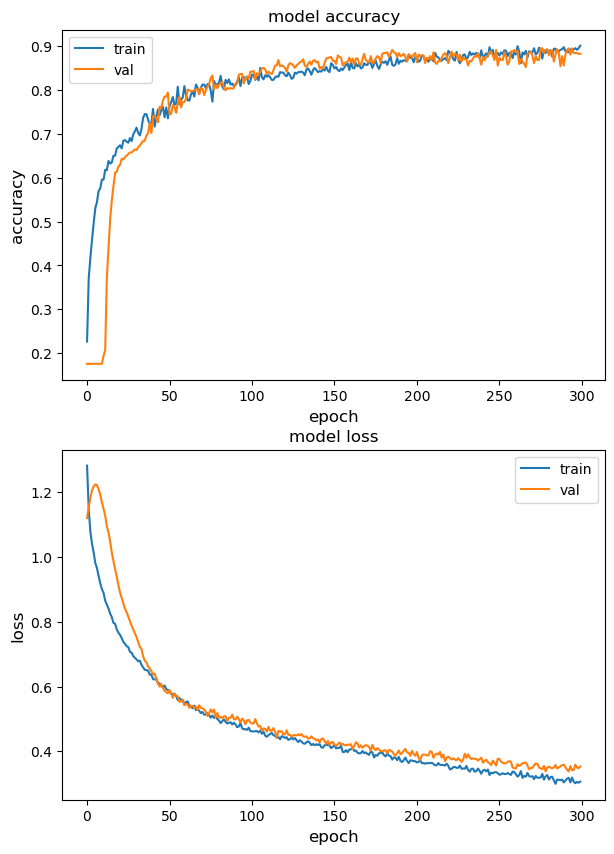

In [26]:
plt.figure(figsize=(7, 10))
metric = "accuracy"
plt.subplot(2, 1, 1)
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")

plt.subplot(2, 1, 2)
metric = "loss"
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

In [17]:
# Saving current model
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model_v2c_20241105.tflite', 'wb') as f:
    f.write(tflite_model)


# save model weights
model.save_weights("model_v2c_20241105.h5")

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpd679rmef\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpd679rmef\assets


In [18]:
# Model Loader:

model = ts_cnn()
model.load_weights("model_v2c_20241105.h5")

In [27]:
idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

print(f'First 5 samples: {y[:5]}') # see a couple of examples
np.argmax(y, axis=1)[:5]

# find how many positive and negative samples are in the dataset
print(f'positive: {np.sum(np.argmax(y, axis=1) == 0)}')
print(f'negative: {np.sum(np.argmax(y, axis=1) == 1)}')

# y_val = np.reshape(y, (len(y),))
y_val = y.argmax(axis=1)
y_pred = np.argmax(model.predict([x[:,0], x[:,1]]), axis=1)

# find how many positive and negative samples are in the predicted dataset
print(f'prediction_negative: {np.sum(y_pred == 0)}')
print(f'prediction_slip: {np.sum(y_pred == 1)}')
print(f'prediction_trip: {np.sum(y_pred == 2)}')

First 5 samples: [[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
positive: 910
negative: 254
44/44 [==============================] - 0s 7ms/step
prediction_negative: 906
prediction_slip: 319
prediction_trip: 183


In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred, labels=[0,1,2])

In [29]:
result

array([[887,  17,   6],
       [ 10, 222,  22],
       [  9,  80, 155]], dtype=int64)

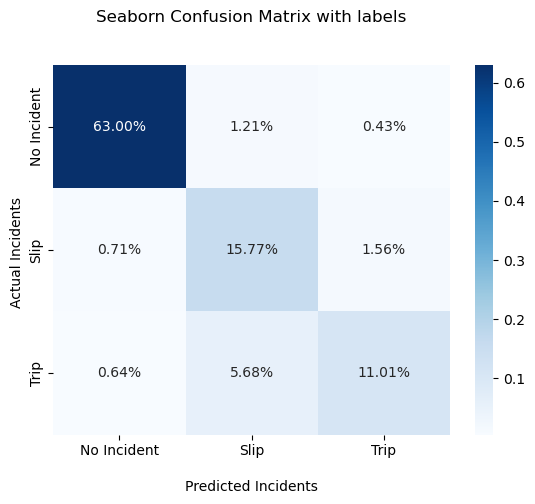

In [30]:
# Old Matrix
# Matrix without labels
ax = sns.heatmap(result/np.sum(result), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Incidents')
ax.set_ylabel('Actual Incidents ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['No Incident','Slip', 'Trip'])
ax.yaxis.set_ticklabels(['No Incident','Slip', 'Trip'])

## Display the visualization of the Confusion Matrix.
plt.show()

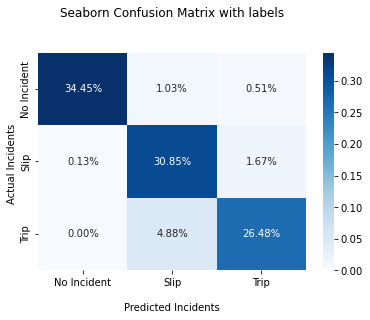

In [19]:
# Matrix without labels
ax = sns.heatmap(result / np.sum(result), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Incidents')
ax.set_ylabel('Actual Incidents ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['No Incident', 'Slip', 'Trip'])
ax.yaxis.set_ticklabels(['No Incident', 'Slip', 'Trip'])

## Display the visualization of the Confusion Matrix.
plt.show()

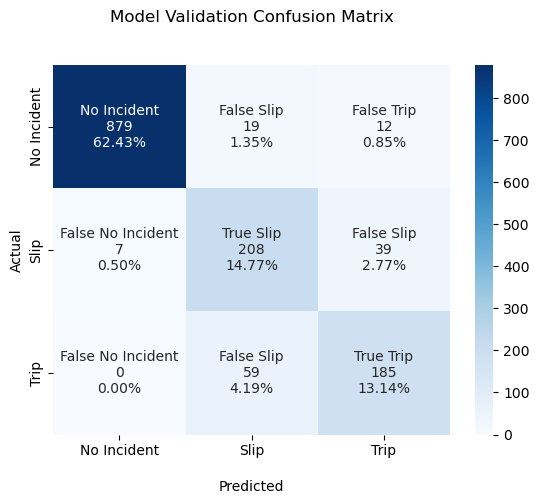

In [23]:
# Matrix with labels
group_names = ['No Incident','False Slip','False Trip',
                'False No Incident', 'True Slip', 'False Slip',
                'False No Incident', 'False Slip', 'True Trip']
group_counts = ["{0:0.0f}".format(value) for value in result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in result.flatten()/np.sum(result)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(result, annot=labels, fmt='', cmap='Blues')
ax.set_title('Model Validation Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['No Incident','Slip', 'Trip'])
ax.yaxis.set_ticklabels(['No Incident','Slip', 'Trip'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [21]:
# Matrix with labels
group_names = ['No Incident','False Pred Incident','False Pred No Inceint','Incident']
group_counts = ["{0:0.0f}".format(value) for value in result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in result.flatten()/np.sum(result)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(result, annot=labels, fmt='', cmap='Blues')
ax.set_title('Model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

ValueError: `data` and `annot` must have same shape.